In [89]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
from ligo.skymap.postprocess import find_greedy_credible_levels
m, meta = read_sky_map('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits')

npix = len(m)
print(npix)

sky_area = 4 * 180**2 / np.pi

nside = hp.npix2nside(npix)
ipix_max = np.argmax(m)
m[ipix_max] / hp.nside2pixarea(nside, degrees=True)
npix = 1891
solid_angle = 4 * np.pi / npix
credible_levels = find_greedy_credible_levels(m)

pixel_area_deg2 = np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print(pixel_area_deg2)
#Convert square degrees to square arcseconds
area_arcsec2 = pixel_area_deg2 * (3600**2)
#Convert square arcseconds to square parsecs using the conversion factor
area_pc2 = area_arcsec2 / (0.2679**2)
#Convert square parsecs to square megaparsecs (Mpc^2)
area_mpc2 = area_pc2 / 10**12
print(area_mpc2)
Volume  = solid_angle * 1000**3
print(Volume)


3145728
7037.477215095633
1.2707981563382371
6645357.2788784625


In [57]:
from astropy.cosmology import Planck18 as cosmo
import numpy as np
z = 1  # Set the redshift to 1 for this calculation
comvol = cosmo.comoving_volume(z).value
print('Comvol:',comvol)
r = cosmo.comoving_distance(z).value
dV = 4/3 * np.pi * r**3
print('dV:', dV)

Comvol: 164002855773.57907
dV: 164002855773.57907


# Volume

In [81]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah

def calculate_pixel_volumes(skymap_file, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        #Convert square degrees to square arcseconds
        area_arcsec2 = pixel_area_deg2 * (3600**2)
        #Convert square arcseconds to square parsecs using the conversion factor
        area_pc2 = area_arcsec2 / (0.2679**2)
        #Convert square parsecs to square megaparsecs (Mpc^2)
        area_mpc2 = area_pc2 / 10**12
        
        dist = 1000
        # Calculate the volume for this pixel
        volumes[i] = (area_mpc2 * dist)*10e-9 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
# Example usage
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
target_probability = 0.1
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, target_probability)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.14f} Gpc^3")
print('Total Volume:', np.sum(pixel_volumes_in_90_percent['volume_Gpc3']), 'Gpc^3')

Pixel 17554: Volume = 0.00000000002368 Gpc^3
Pixel 17553: Volume = 0.00000000002368 Gpc^3
Pixel 17549: Volume = 0.00000000002368 Gpc^3
Pixel 17550: Volume = 0.00000000002368 Gpc^3
Pixel 17543: Volume = 0.00000000002368 Gpc^3
Total Volume: 4.478010050752099e-08 Gpc^3


# Volume with redshift dependence

In [58]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah

def calculate_pixel_volumes(skymap_file,z, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        z = 1  # Set the redshift to 1 for this calculation
        comvol = cosmo.comoving_volume(z).value
        # Calculate the volume for this pixel
        volumes[i] = (comvol * 1e-9) * pixel_area_deg2 / 41253.0 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
# Example usage
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
target_probability = 0.1
z = 1
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z, target_probability)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.14f} Gpc^3")
print('Total Volume:', np.sum(pixel_volumes_in_90_percent['volume_Gpc3']), 'Gpc^3')

Pixel 17554: Volume = 0.00005213505482 Gpc^3
Pixel 17553: Volume = 0.00005213505482 Gpc^3
Pixel 17549: Volume = 0.00005213505482 Gpc^3
Pixel 17550: Volume = 0.00005213505482 Gpc^3
Pixel 17543: Volume = 0.00005213505482 Gpc^3
Total Volume: 0.09858738865883493 Gpc^3


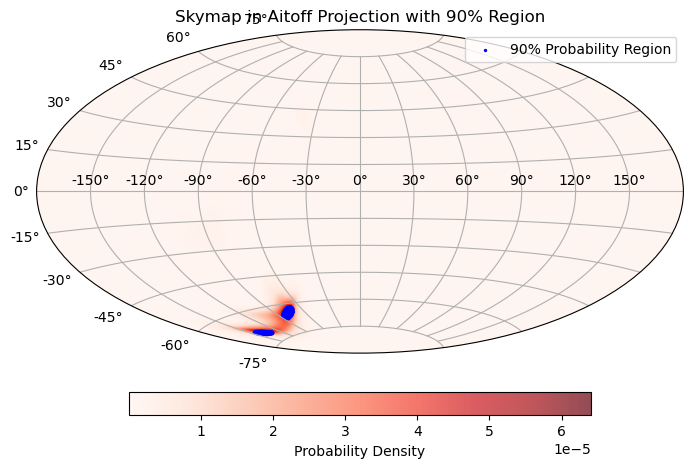

Number of pixels in 90% region: 1891
Matching pixels found: 1891
Pixel 17554: Volume = 0.000052135054817 Gpc^3
Pixel 17553: Volume = 0.000052135054817 Gpc^3
Pixel 17549: Volume = 0.000052135054817 Gpc^3
Pixel 17550: Volume = 0.000052135054817 Gpc^3
Pixel 17543: Volume = 0.000052135054817 Gpc^3
Total volume in the 90% probability region: 9.8587388659e-02 Gpc^3

Sampled transients in the enclosed region:
SNIa: 2227
CCSN: 10054
SLSN: 2
KN: 536
GRB_on_axis: 0
GRB_off_axis: 0
CV: 98417


In [59]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy_healpix as ah
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    # Debug: Print out matching information
    print(f"Number of pixels in 90% region: {len(pixels_in_target_percent)}")
    print(f"Matching pixels found: {len(skymap_pixels_in_target_percent)}")
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file,z, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        z = 1  # Set the redshift to 1 for this calculation
        comvol = cosmo.comoving_volume(z).value
        # Calculate the volume for this pixel
        volumes[i] = (comvol * 1e-9) * pixel_area_deg2 / 41253.0 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    

    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Gpc3'] 

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3']) 
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates)

# Sample the number of transients based on expected values
sampled_transients = sample_transients(total_expected_transients)

# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in sampled_transients.items():
    print(f"{transient}: {sampled_count}")

# With Time Window

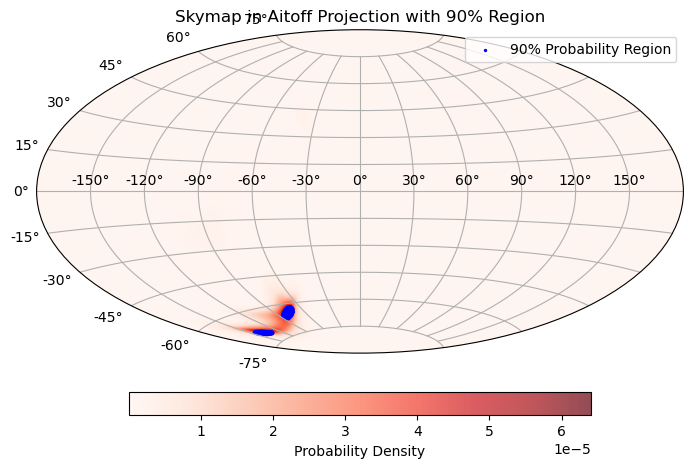

Pixel 17554: Volume = 0.000052135054817 Gpc^3
Pixel 17553: Volume = 0.000052135054817 Gpc^3
Pixel 17549: Volume = 0.000052135054817 Gpc^3
Pixel 17550: Volume = 0.000052135054817 Gpc^3
Pixel 17543: Volume = 0.000052135054817 Gpc^3
Total volume in the 90% probability region: 9.8587388659e-02 Gpc^3

Sampled transients in the enclosed region:
SNIa: 44.401438560924994
CCSN: 190.83171466611788
SLSN: 0.010580768337922668
KN: 9.447114587431075
GRB_on_axis: 0.0018894229174861866
GRB_off_axis: 0.013225960422403989
CV: 1889.4229174861835


In [61]:
import numpy as np
import healpy as hp
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    # Match RA and Dec within some tolerance (e.g., 1e-6 degrees)
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file,z, target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        z = 1  # Set the redshift to 1 for this calculation
        comvol = cosmo.comoving_volume(z).value
        # Calculate the volume for this pixel
        volumes[i] = (comvol * 1e-9) * pixel_area_deg2 / 41253.0 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes
    
def calculate_expected_transients(volumes, transients_rates, days):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            expected_events = rate * volume * days / 365.25
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    # Convert HEALPix coordinates to equatorial coordinates for Aitoff projection
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta

    # Adjust the range of ra_rad to [-pi, pi] for Aitoff projection
    ra_rad = ra_rad - np.pi

    # Convert the selected pixels back to RA and Dec for plotting
    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    
    # Create the Aitoff projection plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Plot the skymap
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)

    # Plot the specific 90% probability region
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'  
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}
days = 7
z = 1
# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

# Calculate volumes for the 90% area
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")


# Convert volumes to Gpc^3
volumes_gpc3 = pixel_volumes_in_90_percent['volume_Gpc3'] 

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3']) 
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Calculate expected transients in the 90% probability region
total_expected_transients = calculate_expected_transients(volumes_gpc3, transients_rates, days)

# Sample the number of transients based on expected values
# Print the sampled number of transients
print("\nSampled transients in the enclosed region:")
for transient, sampled_count in total_expected_transients.items():
    print(f"{transient}: {sampled_count}")


# 100 simulations

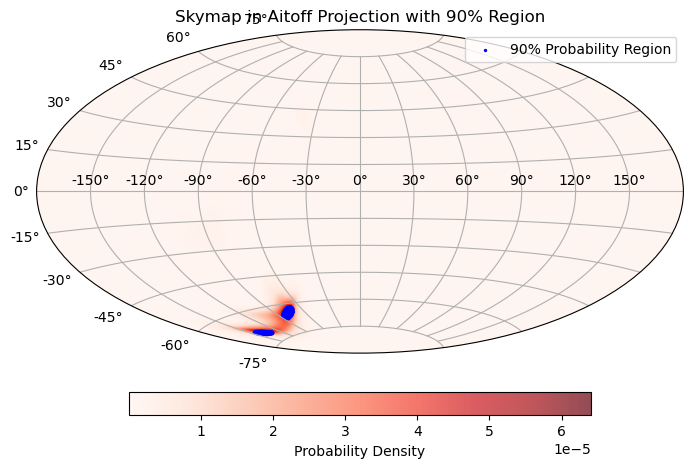

Pixel 17554: Volume = 0.000052135054817 Gpc^3
Pixel 17553: Volume = 0.000052135054817 Gpc^3
Pixel 17549: Volume = 0.000052135054817 Gpc^3
Pixel 17550: Volume = 0.000052135054817 Gpc^3
Pixel 17543: Volume = 0.000052135054817 Gpc^3
Total volume in the 90% probability region: 9.8587388659e-02 Gpc^3

Mean and standard deviation of expected transients over 100 simulations:
SNIa: Mean = 44.401438561, Std = 0.000000000
CCSN: Mean = 190.831714666, Std = 0.000000000
SLSN: Mean = 0.010580768, Std = 0.000000000
KN: Mean = 9.447114587, Std = 0.000000000
GRB_on_axis: Mean = 0.001889423, Std = 0.000000000
GRB_off_axis: Mean = 0.013225960, Std = 0.000000000
CV: Mean = 1889.422917486, Std = 0.000000000

Sampled transients using Poisson distribution based on the mean of expected values:
SNIa: 47
CCSN: 222
SLSN: 0
KN: 6
GRB_on_axis: 0
GRB_off_axis: 0
CV: 1903


In [62]:
import numpy as np
import healpy as hp
import lal
import astropy_healpix as ah
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt

def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Find the corresponding UNIQ values directly from skymap
    uniq_values = skymap['UNIQ']
    
    # Calculate the corresponding RA and Dec for the UNIQ values in the skymap
    level, ipix = ah.uniq_to_level_ipix(uniq_values)
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    skymap_pixels_in_target_percent = skymap[matched_indices]
    
    # Calculate area
    pixel_area = hp.nside2pixarea(nside)
    total_area_target_percent = len(pixels_in_target_percent) * pixel_area
    total_area_target_percent_deg2 = total_area_target_percent * (180 / np.pi)**2
    
    plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent)
    
    return total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside

def calculate_pixel_volumes(skymap_file, z,target_probability=0.1):
    # Read the sky map data
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    # Ensure nside is derived properly
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert HEALPix pixel indices to UNIQ indices
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    # Match the RA, Dec of the pixels to the sky map UNIQ
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
    nside_sky = ah.level_to_nside(level)
    ra_sky, dec_sky = ah.healpix_to_lonlat(ipix, nside_sky, order='nested')
    
    matched_indices = []
    for ra, dec in zip(ra_deg, dec_deg):
        matched = np.where((np.abs(ra_sky.deg - ra) < 1e-6) & (np.abs(dec_sky.deg - dec) < 1e-6))[0]
        if len(matched) > 0:
            matched_indices.extend(matched)
    
    matched_indices = np.array(matched_indices)
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(matched_indices))
    # Loop over each matched pixel to calculate volumes
    for i, idx in enumerate(matched_indices):
        sky_map_size = 41253 
        pixel_area_deg2 =  hp.nside2pixarea(nside, degrees=True)
        comvol = cosmo.comoving_volume(z).value # Units: Mpc^3
        
        # Calculate the volume for this pixel
        volumes[i] = (comvol * pixel_area_deg2 / sky_map_size)*1e-9 # Gpc^3
    
    # Create a structured array to store pixel index, volume, and corresponding distances
    pixel_volumes = np.zeros(len(matched_indices), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = matched_indices
    pixel_volumes['volume_Gpc3'] = volumes

    
    return pixel_volumes

def calculate_expected_transients(volumes, transients_rates, days):
    total_expected_transients = {transient: 0 for transient in transients_rates}
    
    for volume in volumes:
        for transient, rate in transients_rates.items():
            # Adjust the rate to the given time window (e.g., 2 days)
            expected_events = rate * volume * (days / 365.25) 
            total_expected_transients[transient] += expected_events
    
    return total_expected_transients

def sample_transients(expected_transients):
    sampled_transients = {transient: np.random.poisson(lam=total_count)
                          for transient, total_count in expected_transients.items()}
    return sampled_transients

def plot_skymap_with_90_percent_region(m, nside, pixels_in_target_percent):
    theta, phi = hp.pix2ang(nside, np.arange(len(m)))
    ra_rad = phi
    dec_rad = 0.5 * np.pi - theta
    ra_rad = ra_rad - np.pi

    theta_90, phi_90 = hp.pix2ang(nside, pixels_in_target_percent)
    ra_90 = phi_90 - np.pi
    dec_90 = 0.5 * np.pi - theta_90
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)
    
    sc = ax.scatter(ra_rad, dec_rad, c=m, s=5, cmap='Reds', alpha=0.7, linewidth=0)
    ax.scatter(ra_90, dec_90, color='blue', marker='o', s=2, label='90% Probability Region')
    
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", fraction=0.06, pad=0.1)
    cbar.set_label('Probability Density')

    plt.title("Skymap in Aitoff Projection with 90% Region")
    plt.legend(loc=1)
    plt.show()

def run_transient_simulations(num_simulations, pixel_volumes, transients_rates, days):
    all_expected_transients = {transient: [] for transient in transients_rates}
    
    for _ in range(num_simulations):
        expected_transients = calculate_expected_transients(pixel_volumes, transients_rates, days)
        for transient, expected_count in expected_transients.items():
            all_expected_transients[transient].append(expected_count)
    
    # Calculate mean and standard deviation for each transient
    mean_expected_transients = {transient: np.mean(counts) for transient, counts in all_expected_transients.items()}
    std_expected_transients = {transient: np.std(counts) for transient, counts in all_expected_transients.items()}
    
    # Sample transients using Poisson distribution based on the mean
    sampled_transients_poisson = {transient: np.random.poisson(lam=mean_count)
                                  for transient, mean_count in mean_expected_transients.items()}
    
    return mean_expected_transients, std_expected_transients, sampled_transients_poisson

# Ensure the skymap file path is correct
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,   # Use a refined rate near the galactic plane
}

# Calculate the 90% area and get the corresponding pixels
total_area_target_percent_deg2, skymap_pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)

z = 1
days = 7
# Calculate volumes for the 90% area using redshift sensitivity

pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z, target_probability=0.1)

# Print the first few pixel volumes within the 90% region
for i in range(min(5, len(pixel_volumes_in_90_percent))):
    print(f"Pixel {pixel_volumes_in_90_percent['pixel_index'][i]}: Volume = {pixel_volumes_in_90_percent['volume_Gpc3'][i]:.15f} Gpc^3")

# Sum volumes to get the total volume in the 90% area
total_volume = np.sum(pixel_volumes_in_90_percent['volume_Gpc3'])
print(f"Total volume in the 90% probability region: {total_volume:.10e} Gpc^3")

# Number of simulations
num_simulations = 100


# Run the simulations
mean_expected_transients, std_expected_transients, sampled_transients_poisson = run_transient_simulations(
    num_simulations, pixel_volumes_in_90_percent['volume_Gpc3'], transients_rates, days
)

# Print the mean and standard deviation of the expected transients
print("\nMean and standard deviation of expected transients over 100 simulations:")
for transient in transients_rates.keys():
    print(f"{transient}: Mean = {mean_expected_transients[transient]:.9f}, Std = {std_expected_transients[transient]:.9f}")

# Print the sampled number of transients based on Poisson distribution
print(f"\nSampled transients using Poisson distribution based on the mean of expected values:")
for transient, sampled_count in sampled_transients_poisson.items():
    print(f"{transient}: {sampled_count}")

# PDF(dist)

In [20]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
from astropy.cosmology import Planck18 as cosmo, z_at_value
import matplotlib.pyplot as plt

# Function to calculate the 90% probability region in a sky map
def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    return ra_deg, dec_deg, pixels_in_target_percent, nside

# Function to calculate the volume of each pixel in the 90% region
def calculate_pixel_volumes(skymap_file, z, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(pixels_in_target_percent))
    for i, pixel_index in enumerate(pixels_in_target_percent):
        sky_map_size = 41253  # Total sky area in deg^2
        pixel_area_deg2 = hp.nside2pixarea(nside, degrees=True)
        comvol = cosmo.comoving_volume(z).value  # Units: Mpc^3
        
        # Calculate the volume for this pixel
        volumes[i] = (comvol * pixel_area_deg2 / sky_map_size) * 1e-9  # Convert to Gpc^3
    
    # Create a structured array to store pixel index and volume
    pixel_volumes = np.zeros(len(pixels_in_target_percent), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = pixels_in_target_percent
    pixel_volumes['volume_Gpc3'] = volumes
    
    return pixel_volumes

# Function to sample radii (comoving distances) for events evenly distributed in a sphere
def pdf_radii(num_events, sphere_radius=3500):
    """
    Sample comoving radii for events evenly distributed in a sphere.
    Args:
        num_events (int): The number of events to sample.
        sphere_radius (float): The maximum radius of the sphere in Mpc.
    
    Returns:
        radii (array): Array of sampled comoving radii for the events.
    """
    # The maximum redshift corresponding to the sphere_radius
    max_redshift = z_at_value(cosmo.comoving_distance, sphere_radius * u.Mpc)
    
    # Sample uniform values between 0 and 1, and then apply the cube root to get radial distribution
    uniform = np.random.uniform(0, 1, num_events)
    comoving_radii = cosmo.comoving_distance(max_redshift).value * np.cbrt(uniform)  # In Mpc
    
    return comoving_radii

# Function to calculate the redshift from a given comoving distance (Mpc)
def calculate_redshift_from_distance(distance_mpc):
    """
    Calculate the redshift corresponding to a given comoving distance.
    
    Args:
        distance_mpc (float): The comoving distance in Mpc.
    
    Returns:
        float: The redshift corresponding to the comoving distance.
    """
    # Convert distance to an Astropy quantity with units
    distance_with_unit = distance_mpc * u.Mpc
    
    # Calculate the corresponding redshift
    redshift = z_at_value(cosmo.comoving_distance, distance_with_unit)
    
    return redshift

# Function to calculate the expected number of transients for each type
def calculate_expected_transients(pixel_volumes, transients_rates, time_days=7):
    total_volume_gpc3 = np.sum(pixel_volumes['volume_Gpc3'])
    time_years = time_days / 365.25  # Convert time to years
    
    expected_transients = {}
    for transient_name, rate_per_gpc3_per_year in transients_rates.items():
        expected_events = rate_per_gpc3_per_year * total_volume_gpc3 * time_years
        expected_transients[transient_name] = expected_events
    
    return expected_transients

# Function to run Monte Carlo simulations and sample transients
def run_transient_simulations(num_simulations, pixel_volumes, transients_rates, time_days=7):
    all_expected_transients = {transient: [] for transient in transients_rates}
    
    for _ in range(num_simulations):
        expected_transients = calculate_expected_transients(pixel_volumes, transients_rates, time_days)
        for transient, expected_count in expected_transients.items():
            all_expected_transients[transient].append(expected_count)
    
    mean_expected_transients = {transient: np.mean(counts) for transient, counts in all_expected_transients.items()}
    sampled_transients_poisson = {transient: np.random.poisson(lam=mean_count)
                                  for transient, mean_count in mean_expected_transients.items()}
    
    return sampled_transients_poisson

# Function to assign RA/Dec and redshifts for the sampled transients
def assign_ra_dec_for_transients(transient_name, ra_90, dec_90, pixel_volumes, num_samples):
    """
    Assign random RA/Dec and redshifts for each transient in the 90% sky region.
    
    Args:
        transient_name (str): The name of the transient type.
        ra_90 (array): Array of RA values for the 90% sky region.
        dec_90 (array): Array of Dec values for the 90% sky region.
        pixel_volumes (array): Array of volumes for the pixels in the 90% region.
        num_samples (int): The number of samples to generate for this transient type.
    
    Returns:
        list: List of tuples (transient_name, RA, Dec, redshift).
    """
    transients_ra_dec_z = []
    
    # For each transient, sample a random location and redshift
    for i in range(num_samples):
        # Randomly select a pixel within the 90% region
        idx = np.random.choice(len(ra_90))  # Randomly choose an index from the 90% region
        ra, dec = ra_90[idx], dec_90[idx]
        
        # Sample a comoving distance for the transient
        distance_mpc = pdf_radii(1)[0]  # Sample one comoving distance
        
        # Convert comoving distance to redshift
        redshift = calculate_redshift_from_distance(distance_mpc)
        
        transients_ra_dec_z.append((transient_name, ra, dec, redshift))
    
    return transients_ra_dec_z
    

    
# Main execution example
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
time_days = 7  # Time window for transient event rate
num_simulations = 100  # Number of simulation runs
z = 1
# Transient event rates in Gpc^-3 yr^-1
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    #'CV': 1e6,   # Use a refined rate near the galactic plane
}

# Step 1: Calculate the 90% probability region and volumes for the sky map
ra_90, dec_90, pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z=1, target_probability=0.1)

# Step 2: Run transient simulations to get sampled events based on volume and rates
sampled_transients_poisson = run_transient_simulations(num_simulations, pixel_volumes_in_90_percent, transients_rates, time_days)

# Step 3: Assign RA/Dec and redshifts for each transient based on the sampled numbers
all_transients = []
transient_counts = {key: 0 for key in transients_rates.keys()}  # Initialize the counts for each transient type

for transient_name, num_samples in sampled_transients_poisson.items():
    transients_ra_dec_z = assign_ra_dec_for_transients(transient_name, ra_90, dec_90, pixel_volumes_in_90_percent, num_samples)
    all_transients.extend(transients_ra_dec_z)
    transient_counts[transient_name] += num_samples  # Update the count for each transient type

# Print the counts of each transient type
print("\nCounts of each transient type:")
for transient_name, count in transient_counts.items():
    print(f"{transient_name}: {count}")
# Output the sampled transients' names, locations, redshifts, and counts
for i, (transient_name, ra, dec, z) in enumerate(all_transients):
    print(f"Transient {i+1}: Type = {transient_name}, RA = {ra:.4f}°, Dec = {dec:.4f}°, Redshift = {z:.4f}")




Counts of each transient type:
SNIa: 43
CCSN: 172
SLSN: 0
KN: 10
GRB_on_axis: 0
GRB_off_axis: 0
Transient 1: Type = SNIa, RA = 40.9276°, Dec = -69.7011°, Redshift = 0.9582 redshift
Transient 2: Type = SNIa, RA = 105.2135°, Dec = -64.1050°, Redshift = 0.6937 redshift
Transient 3: Type = SNIa, RA = 35.6494°, Dec = -68.7722°, Redshift = 0.8720 redshift
Transient 4: Type = SNIa, RA = 98.8662°, Dec = -65.2288°, Redshift = 0.8799 redshift
Transient 5: Type = SNIa, RA = 102.6404°, Dec = -65.4159°, Redshift = 0.7897 redshift
Transient 6: Type = SNIa, RA = 94.8876°, Dec = -65.4159°, Redshift = 0.6536 redshift
Transient 7: Type = SNIa, RA = 104.5408°, Dec = -62.8847°, Redshift = 0.8150 redshift
Transient 8: Type = SNIa, RA = 99.2007°, Dec = -65.2288°, Redshift = 0.4968 redshift
Transient 9: Type = SNIa, RA = 100.1667°, Dec = -65.1352°, Redshift = 0.6425 redshift
Transient 10: Type = SNIa, RA = 109.0206°, Dec = -63.1666°, Redshift = 0.7827 redshift
Transient 11: Type = SNIa, RA = 39.8394°, Dec =

Transient 1: Type = SNIa, RA = 97.0879°, Dec = -64.8545°, Redshift = 0.6855 redshift
Transient 2: Type = SNIa, RA = 36.3462°, Dec = -68.4932°, Redshift = 0.3947 redshift
Transient 3: Type = SNIa, RA = 110.0167°, Dec = -62.4145°, Redshift = 0.9493 redshift
Transient 4: Type = SNIa, RA = 46.4858°, Dec = -70.5359°, Redshift = 0.9233 redshift
Transient 5: Type = SNIa, RA = 48.0144°, Dec = -70.8140°, Redshift = 0.8704 redshift
Transient 6: Type = SNIa, RA = 35.9615°, Dec = -68.4932°, Redshift = 1.0229 redshift
Transient 7: Type = SNIa, RA = 107.4338°, Dec = -62.1322°, Redshift = 0.7033 redshift
Transient 8: Type = SNIa, RA = 101.8592°, Dec = -64.4799°, Redshift = 0.6242 redshift
Transient 9: Type = SNIa, RA = 104.2187°, Dec = -63.4483°, Redshift = 1.0235 redshift
Transient 10: Type = SNIa, RA = 38.2112°, Dec = -68.6792°, Redshift = 0.5082 redshift
Transient 11: Type = SNIa, RA = 95.5138°, Dec = -66.7235°, Redshift = 0.9605 redshift
Transient 12: Type = SNIa, RA = 96.9623°, Dec = -65.6029°, 

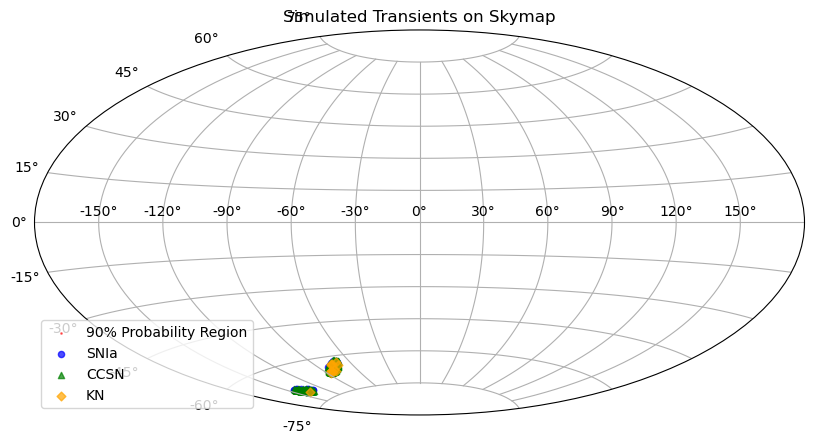

In [13]:
import numpy as np
import healpy as hp
from astropy.table import QTable
import astropy.units as u
from ligo.skymap.io import read_sky_map
from astropy.cosmology import Planck18 as cosmo, z_at_value
import matplotlib.pyplot as plt

# Function to calculate the 90% probability region in a sky map
def calculate_sky_area_90_percent(skymap_file, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Convert pixel indices to RA, Dec
    theta, phi = hp.pix2ang(nside, pixels_in_target_percent)
    ra_deg = np.degrees(phi)
    dec_deg = np.degrees(0.5 * np.pi - theta)
    
    return ra_deg, dec_deg, pixels_in_target_percent, nside

# Function to calculate the volume of each pixel in the 90% region
def calculate_pixel_volumes(skymap_file, z, target_probability=0.1):
    m, meta = read_sky_map(skymap_file)
    skymap = QTable.read(skymap_file)
    
    nside = meta.get('nside', hp.get_nside(m))
    
    # Sort the map by probability density
    sorted_indices = np.argsort(m)[::-1]
    sorted_prob_density = m[sorted_indices]
    cumulative_prob = np.cumsum(sorted_prob_density)
    
    index_target_percent = np.where(cumulative_prob >= target_probability)[0][0]
    pixels_in_target_percent = sorted_indices[:index_target_percent+1]
    
    # Initialize arrays to store volumes
    volumes = np.zeros(len(pixels_in_target_percent))
    for i, pixel_index in enumerate(pixels_in_target_percent):
        sky_map_size = 41253  # Total sky area in deg^2
        pixel_area_deg2 = hp.nside2pixarea(nside, degrees=True)
        comvol = cosmo.comoving_volume(z).value  # Units: Mpc^3
        
        # Calculate the volume for this pixel
        volumes[i] = (comvol * pixel_area_deg2 / sky_map_size) * 1e-9  # Convert to Gpc^3
    
    # Create a structured array to store pixel index and volume
    pixel_volumes = np.zeros(len(pixels_in_target_percent), dtype=[('pixel_index', int), ('volume_Gpc3', float)])
    pixel_volumes['pixel_index'] = pixels_in_target_percent
    pixel_volumes['volume_Gpc3'] = volumes
    
    return pixel_volumes

# Function to sample radii (comoving distances) for events evenly distributed in a sphere
def pdf_radii(num_events, sphere_radius=3500):
    """
    Sample comoving radii for events evenly distributed in a sphere.
    Args:
        num_events (int): The number of events to sample.
        sphere_radius (float): The maximum radius of the sphere in Mpc.
    
    Returns:
        radii (array): Array of sampled comoving radii for the events.
    """
    # The maximum redshift corresponding to the sphere_radius
    max_redshift = z_at_value(cosmo.comoving_distance, sphere_radius * u.Mpc)
    
    # Sample uniform values between 0 and 1, and then apply the cube root to get radial distribution
    uniform = np.random.uniform(0, 1, num_events)
    comoving_radii = cosmo.comoving_distance(max_redshift).value * np.cbrt(uniform)  # In Mpc
    
    return comoving_radii

# Function to calculate the redshift from a given comoving distance (Mpc)
def calculate_redshift_from_distance(distance_mpc):
    """
    Calculate the redshift corresponding to a given comoving distance.
    
    Args:
        distance_mpc (float): The comoving distance in Mpc.
    
    Returns:
        float: The redshift corresponding to the comoving distance.
    """
    # Convert distance to an Astropy quantity with units
    distance_with_unit = distance_mpc * u.Mpc
    
    # Calculate the corresponding redshift
    redshift = z_at_value(cosmo.comoving_distance, distance_with_unit)
    
    return redshift

# Function to calculate the expected number of transients for each type
def calculate_expected_transients(pixel_volumes, transients_rates, time_days=7):
    total_volume_gpc3 = np.sum(pixel_volumes['volume_Gpc3'])
    time_years = time_days / 365.25  # Convert time to years
    
    expected_transients = {}
    for transient_name, rate_per_gpc3_per_year in transients_rates.items():
        expected_events = rate_per_gpc3_per_year * total_volume_gpc3 * time_years
        expected_transients[transient_name] = expected_events
    
    return expected_transients

# Function to run Monte Carlo simulations and sample transients
def run_transient_simulations(num_simulations, pixel_volumes, transients_rates, time_days=7):
    all_expected_transients = {transient: [] for transient in transients_rates}
    
    for _ in range(num_simulations):
        expected_transients = calculate_expected_transients(pixel_volumes, transients_rates, time_days)
        for transient, expected_count in expected_transients.items():
            all_expected_transients[transient].append(expected_count)
    
    mean_expected_transients = {transient: np.mean(counts) for transient, counts in all_expected_transients.items()}
    sampled_transients_poisson = {transient: np.random.poisson(lam=mean_count)
                                  for transient, mean_count in mean_expected_transients.items()}
    
    return sampled_transients_poisson

# Function to assign RA/Dec and redshifts for the sampled transients
def assign_ra_dec_for_transients(transient_name, ra_90, dec_90, pixel_volumes, num_samples):
    """
    Assign random RA/Dec and redshifts for each transient in the 90% sky region.
    
    Args:
        transient_name (str): The name of the transient type.
        ra_90 (array): Array of RA values for the 90% sky region.
        dec_90 (array): Array of Dec values for the 90% sky region.
        pixel_volumes (array): Array of volumes for the pixels in the 90% region.
        num_samples (int): The number of samples to generate for this transient type.
    
    Returns:
        list: List of tuples (transient_name, RA, Dec, redshift).
    """
    transients_ra_dec_z = []
    
    # For each transient, sample a random location and redshift
    for i in range(num_samples):
        # Randomly select a pixel within the 90% region
        idx = np.random.choice(len(ra_90))  # Randomly choose an index from the 90% region
        ra, dec = ra_90[idx], dec_90[idx]
        
        # Sample a comoving distance for the transient
        distance_mpc = pdf_radii(1)[0]  # Sample one comoving distance
        
        # Convert comoving distance to redshift
        redshift = calculate_redshift_from_distance(distance_mpc)
        
        transients_ra_dec_z.append((transient_name, ra, dec, redshift))
    
    return transients_ra_dec_z
    
def plot_skymap_with_transients(ra_deg, dec_deg, transients_ra_dec_z, nside, title="Transients on Skymap"):
    """
    Plot the skymap with the 90% probability region and overlay transient locations with different colors and markers.
    
    Args:
        ra_deg (array): Array of RA values in degrees for the 90% region.
        dec_deg (array): Array of Dec values in degrees for the 90% region.
        transients_ra_dec_z (list): List of tuples (transient_name, RA, Dec, redshift) for transients.
        nside (int): HEALPix NSIDE parameter of the skymap.
        title (str): Title of the plot.
    """
    # Define colors and markers for each transient type
    transient_styles = {
        'SNIa': {'color': 'blue', 'marker': 'o', 'label': 'SNIa'},
        'CCSN': {'color': 'green', 'marker': '^', 'label': 'CCSN'},
        'SLSN': {'color': 'purple', 'marker': 's', 'label': 'SLSN'},
        'KN': {'color': 'orange', 'marker': 'D', 'label': 'KN'},
        'GRB_on_axis': {'color': 'red', 'marker': 'v', 'label': 'GRB on-axis'},
        'GRB_off_axis': {'color': 'cyan', 'marker': '>', 'label': 'GRB off-axis'},
        'CV': {'color': 'magenta', 'marker': 'P', 'label': 'CV'}
    }
    
    # Convert RA/Dec to radians for the 90% region
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    ra_rad = ra_rad - np.pi  # Shift to [-π, π] for Aitoff projection
    
    # Create the figure and axis for Aitoff projection
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection="aitoff")
    
    # Plot the 90% probability region as red dots
    ax.scatter(ra_rad, dec_rad, color='red', s=1, label="90% Probability Region", alpha=0.5)
    
    # Plot each transient with a different color and marker
    for transient_name, ra, dec, _ in transients_ra_dec_z:
        style = transient_styles.get(transient_name, {'color': 'black', 'marker': 'o', 'label': 'Unknown'})
        ax.scatter(np.radians(ra - 180), np.radians(dec), color=style['color'], marker=style['marker'], s=20, label=style['label'], alpha=0.7)
    
    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Set title and labels
    plt.title(title)
    plt.grid(True)
    plt.legend(by_label.values(), by_label.keys(), loc='lower left')
    
    # Show the plot
    plt.show()
    
# Main execution example
skymap_file = '/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/nsbh_allsky/14.fits'
time_days = 7  # Time window for transient event rate
num_simulations = 100  # Number of simulation runs
z = 1
# Transient event rates in Gpc^-3 yr^-1
transients_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    #'CV': 1e6,   # Use a refined rate near the galactic plane
}

# Step 1: Calculate the 90% probability region and volumes for the sky map
ra_90, dec_90, pixels_in_target_percent, nside = calculate_sky_area_90_percent(skymap_file)
pixel_volumes_in_90_percent = calculate_pixel_volumes(skymap_file, z=1, target_probability=0.1)

# Step 2: Run transient simulations to get sampled events based on volume and rates
sampled_transients_poisson = run_transient_simulations(num_simulations, pixel_volumes_in_90_percent, transients_rates, time_days)

# Step 3: Assign RA/Dec and redshifts for each transient based on the sampled numbers
all_transients = []
for transient_name, num_samples in sampled_transients_poisson.items():
    transients_ra_dec_z = assign_ra_dec_for_transients(transient_name, ra_90, dec_90, pixel_volumes_in_90_percent, num_samples)
    all_transients.extend(transients_ra_dec_z)

# Output the sampled transients' names, locations, and redshifts
for i, (transient_name, ra, dec, z) in enumerate(all_transients):
    print(f"Transient {i+1}: Type = {transient_name}, RA = {ra:.4f}°, Dec = {dec:.4f}°, Redshift = {z:.4f}")

# Step 4: Plot the transients on the skymap
plot_skymap_with_transients(ra_90, dec_90, all_transients, nside, title="Simulated Transients on Skymap")
